In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.metrics import classification_report, roc_auc_score
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

**Read dataset**

In [2]:
filtered_clothing = pd.read_csv('../filtered_clothing_dataset.csv')

**Split dataset in training and testing set**

In [3]:
eighty_pct = int(0.8*len(filtered_clothing))
  
train_set = filtered_clothing.iloc[:(eighty_pct-1), :] 
test_set = filtered_clothing.iloc[eighty_pct:, :] 
  
train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

**Loading the dataset**

In [4]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [5]:
# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data['id'] = train_data['id'].astype(str) + '.jpg'
test_data['id'] = test_data['id'].astype(str) + '.jpg'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 22344 validated image filenames belonging to 24 classes.
Found 5587 validated image filenames belonging to 24 classes.


**Defining the CNN model**

In [6]:
input_shape = (img_width, img_height, 3)
input_layer = Input(shape=input_shape)

model = Sequential([
    input_layer,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(24, activation='softmax')  # 5 categories in the dataset
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,690,840 (36.97 MB)

 Trainable params: 9,690,840 (36.97 MB)

 Non-trainable params: 0 (0.00 B)

**Model training**

In [7]:
# number of training and validation steps
train_steps_per_epoch = len(train_data) // batch_size
test_steps_per_epoch = len(test_data) // batch_size

# model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch)

Epoch 1/20


C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


698/698 ━━━━━━━━━━━━━━━━━━━━ 1065s 2s/step - accuracy: 0.5287 - loss: 1.4946 - val_accuracy: 0.7516 - val_loss: 0.6996
Epoch 2/20
  1/698 ━━━━━━━━━━━━━━━━━━━━ 3:38 314ms/step - accuracy: 0.7500 - loss: 0.6585

C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - accuracy: 0.7500 - loss: 0.3297 - val_accuracy: 0.6842 - val_loss: 0.3672
Epoch 3/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 861s 1s/step - accuracy: 0.7618 - loss: 0.6775 - val_accuracy: 0.8051 - val_loss: 0.5651
Epoch 4/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.8750 - loss: 0.2176 - val_accuracy: 0.8421 - val_loss: 0.1618
Epoch 5/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - accuracy: 0.7971 - loss: 0.5488 - val_accuracy: 0.8051 - val_loss: 0.5291
Epoch 6/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step - accuracy: 0.9375 - loss: 0.2033 - val_accuracy: 0.7368 - val_loss: 0.2644
Epoch 7/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.8276 - loss: 0.4697 - val_accuracy: 0.8152 - val_loss: 0.5276
Epoch 8/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step - accuracy: 0.7812 - loss: 0.2938 - val_accuracy: 0.8947 - val_loss: 0.1442
Epoch 9/20
698/698 ━━━━━━━━━━━━━━━━━━━━ 854s 1s/step - accuracy: 0.8336 - loss: 0.4399 - val_accuracy: 0

**Save model**

In [8]:
model.save('CNN_model_articles_20epochs_28032024.keras')
print("Saving the model as CNN_model_articles_20epochs_28032024")

Saving the model as CNN_model_articles_20epochs_28032024


**Model evaluation**

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# predicting the probabilities for the test set
y_pred_proba = model.predict(test_generator)

# converting the probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)

# getting the true labels
y_true = test_generator.classes

# computing the precision, recall, f1-score, support
print("Classification Report:")
print(classification_report(y_true, y_pred))

# computing the AUC-ROC score with the multi_class='ovr'
auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (ovr):", auc_roc)

# computing the AUC-ROC score with the multi_class='ovo'
auc_roc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print("AUC-ROC Score (ovo):", auc_roc_ovo)

174/174 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - accuracy: 0.8398 - loss: 0.4723
Test Loss: 0.462859570980072
Test Accuracy: 0.842851996421814
175/175 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       134
           1       0.64      0.70      0.67        40
           2       0.76      0.81      0.78       550
           3       0.97      0.89      0.93        63
           4       0.80      0.85      0.82        79
           5       0.43      0.28      0.34       102
           6       0.74      0.92      0.82       187
           7       0.87      0.69      0.77       134
           8       0.92      0.98      0.95       342
           9       0.78      0.74      0.76       259
          10       0.54      0.42      0.47        50
          11       0.87      0.79      0.83       124
          12       0.50      0.43      0.46        14
          13       0.95      0.55   

**Accuracy per article type**

175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step
Accuracy for subcategory 'Backpacks': 0.8880597014925373
Accuracy for subcategory 'Capris': 0.7
Accuracy for subcategory 'Casual Shoes': 0.8090909090909091
Accuracy for subcategory 'Clutches': 0.8888888888888888
Accuracy for subcategory 'Dresses': 0.8481012658227848
Accuracy for subcategory 'Flats': 0.28431372549019607
Accuracy for subcategory 'Flip Flops': 0.9197860962566845
Accuracy for subcategory 'Formal Shoes': 0.6865671641791045
Accuracy for subcategory 'Handbags': 0.97953216374269
Accuracy for subcategory 'Heels': 0.7374517374517374
Accuracy for subcategory 'Jackets': 0.42
Accuracy for subcategory 'Jeans': 0.7903225806451613
Accuracy for subcategory 'Laptop Bag': 0.42857142857142855
Accuracy for subcategory 'Leggings': 0.5454545454545454
Accuracy for subcategory 'Sandals': 0.7681159420289855
Accuracy for subcategory 'Shirts': 0.953030303030303
Accuracy for subcategory 'Shorts': 0.9345794392523364
Accuracy for subcategory 'Skirts': 0.73

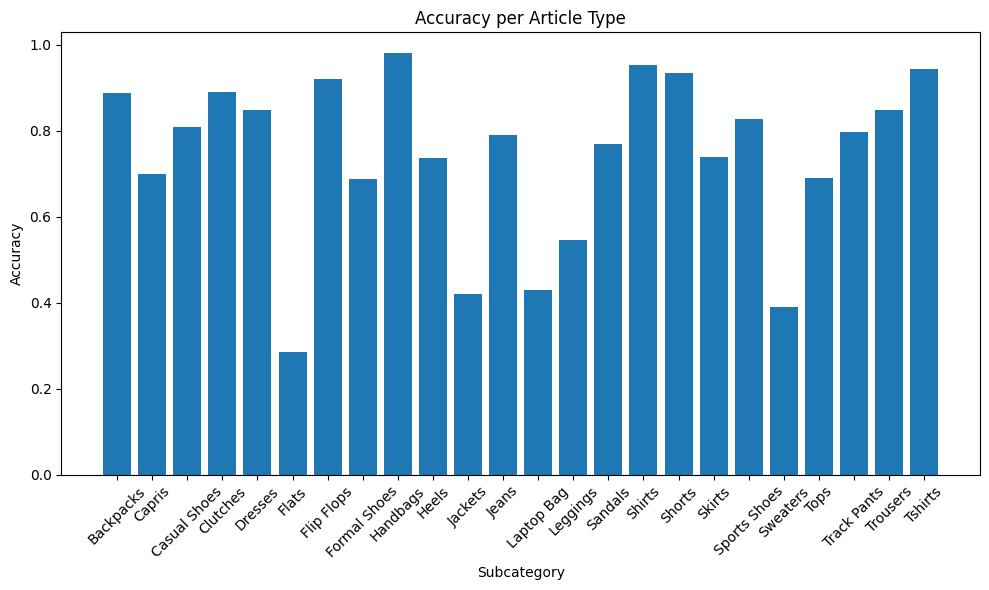

In [10]:
# converting the class_labels to a list
class_labels = list(train_generator.class_indices.keys())

# predicting the probabilities for the test set
predictions = model.predict(test_generator)

# getting the predicted labels for each image
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

# getting the true labels for each image
true_labels = [class_labels[i] for i in test_generator.classes]

# initializing a dictionary to store the counts of the correct predictions and the total counts for each subcategory
subcategory_counts = {class_label: [0, 0] for class_label in class_labels}

# iterating through each prediction and updating the counts
for true_label, predicted_label in zip(true_labels, predicted_labels):
    subcategory_counts[true_label][1] += 1
    if true_label == predicted_label:
        subcategory_counts[true_label][0] += 1

# computing the accuracy for each subcategory
subcategory_accuracies = {class_label: (count[0] / count[1]) if count[1] != 0 else 0 for class_label, count in subcategory_counts.items()}

# displaying the accuracy per subcategory
for class_label, accuracy in subcategory_accuracies.items():
    print(f"Accuracy for subcategory '{class_label}': {accuracy}")

# plotting the accuracy per subcategory
plt.figure(figsize=(10, 6))  
plt.bar(subcategory_accuracies.keys(), subcategory_accuracies.values())
plt.xlabel('Subcategory')
plt.ylabel('Accuracy')
plt.title('Accuracy per Article Type')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()


**Predict the label and accuracy of an external image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


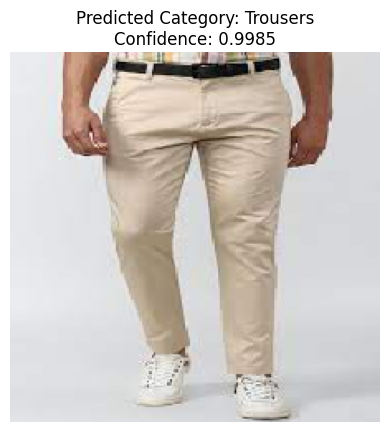

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


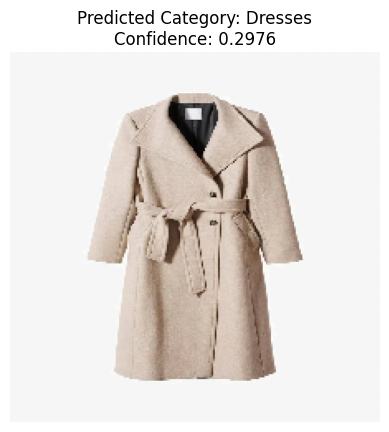

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


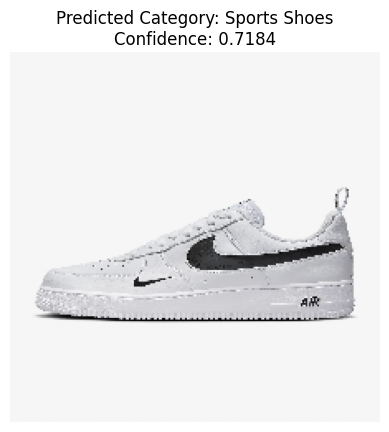

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


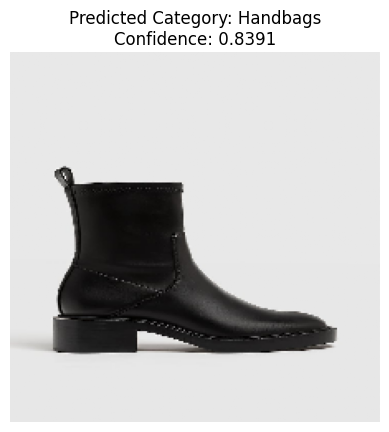

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


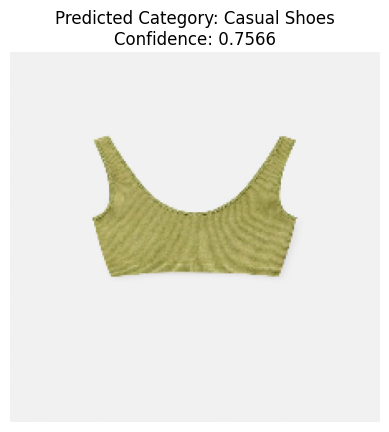

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


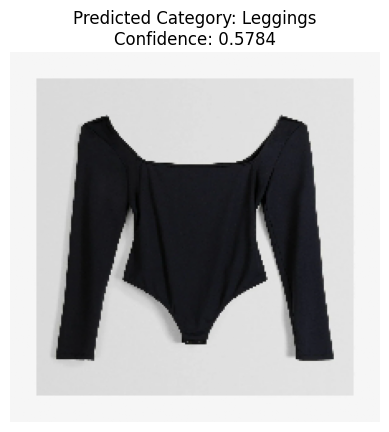

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


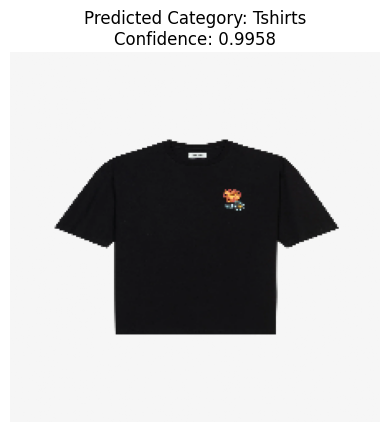

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


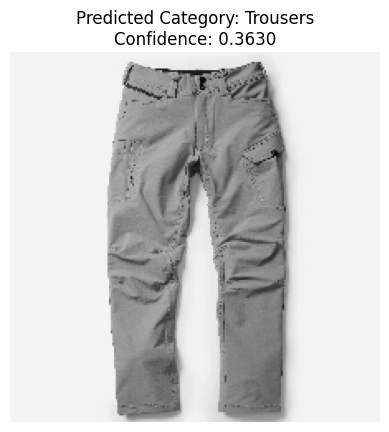

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


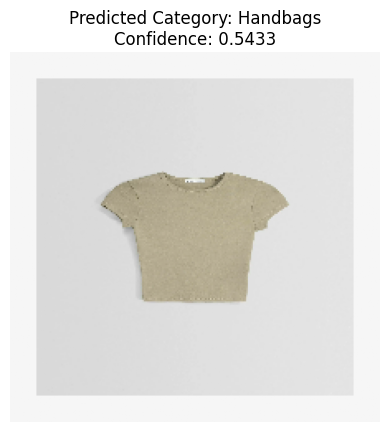

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


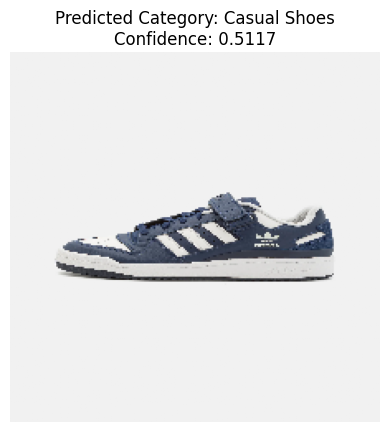

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


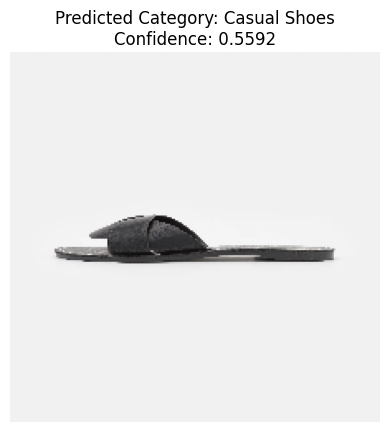

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


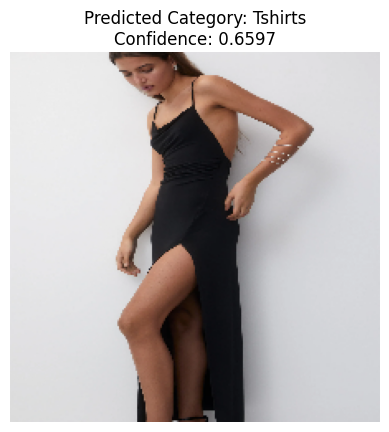

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


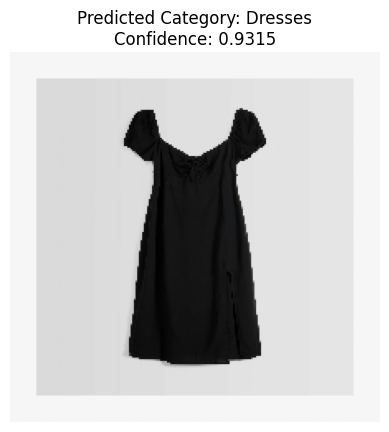

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


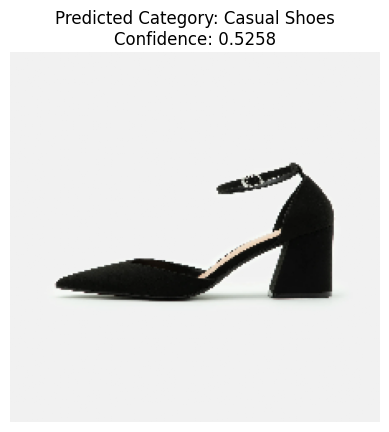

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


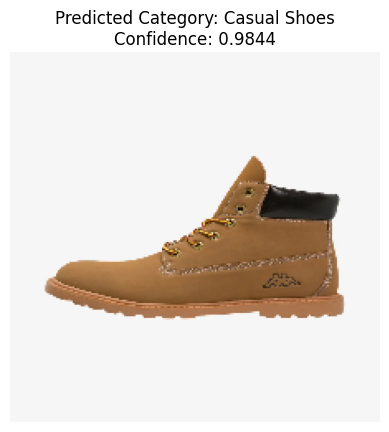

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


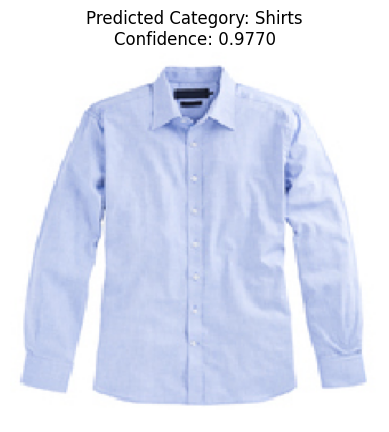

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


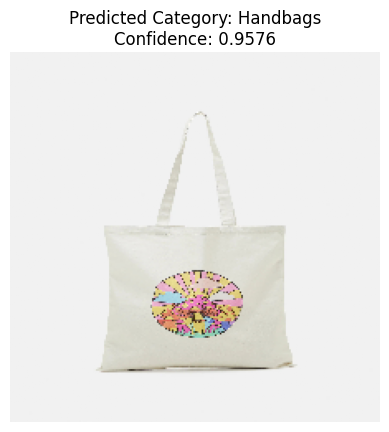

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


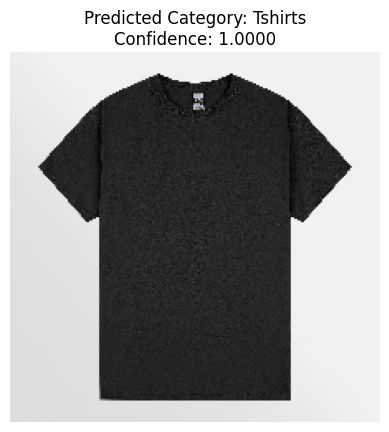

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


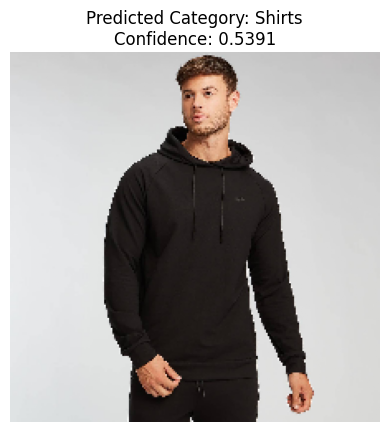

In [11]:
# function to make predictions with dynamically generated category labels
def predict_image_category_with_dynamic_labels(image_path, model, train_generator):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # getting the index of the class with the highest probability
    predicted_class = np.argmax(predictions[0])  
    
    # generating a mapping of the class indices to the category labels
    class_labels = {i: label for i, label in enumerate(train_generator.class_indices.keys())}

    # getting the corresponding label using the class index
    predicted_label = class_labels[predicted_class]  

    # computing the confidence score of the prediction
    confidence = predictions[0][predicted_class] 
    
    return predicted_label, confidence, img_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    return img_array

def parse_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.webp', '.hpg', '.png'))]
    images_data = []
    for file in image_files:
        image_path = os.path.join(folder_path, file)
        preprocessed_image = preprocess_image(image_path)
        images_data.append((image_path, preprocessed_image))
    return images_data


images_folder_path = '../clothing_test_dataset/'

images_data = parse_images_in_folder(images_folder_path)

for image_path, preprocessed_image in images_data:
    # predicting the category and the confidence for the image
    predicted_label, confidence, img_array = predict_image_category_with_dynamic_labels(image_path, model, train_generator)
    
    # displaying the image along with the predicted category and confidence
    plt.imshow(img_array[0])
    plt.title(f'Predicted Category: {predicted_label}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
